In [36]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray
from xeofs.xarray import EOF
import gc
import collections
import statsmodels.api as sm
import scipy
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product
import pyproj
from shapely.geometry import mapping
import pandas as pd

In [2]:
import seaborn as sns
sns.set_theme(style="whitegrid")

In [290]:
plt.rcParams.update({'font.size': 18})
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue')

In [234]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS

# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'

# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Folder for output figures
figures_folderpath = 'reports/figures/' 

interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'
cise_file_path = 'cise_data/'

In [5]:
# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [227]:
# Input data files

regridded_data = xr.open_dataset(inDirName+regriddedFluxSSH_filepath)
flux = regridded_data.timeMonthly_avg_landIceFreshwaterFlux
ssh = regridded_data.timeMonthly_avg_ssh

flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

# change file name for other realizations
flux_reconstr0 = xr.open_dataset(inDirName+interim_data_folder+'flux_reconstr_0.nc')
flux_reconstr0 = flux_reconstr0.reconstructed_data

flux_reconstr1 = xr.open_dataset(inDirName+interim_data_folder+'flux_reconstr_1.nc')
flux_reconstr1 = flux_reconstr1.reconstructed_data

flux_reconstr2 = xr.open_dataset(inDirName+interim_data_folder+'flux_reconstr_2.nc')
flux_reconstr2 = flux_reconstr2.reconstructed_data

flux_reconstr3 = xr.open_dataset(inDirName+interim_data_folder+'flux_reconstr_3.nc')
flux_reconstr3 = flux_reconstr3.reconstructed_data

flux_reconstr4 = xr.open_dataset(inDirName+interim_data_folder+'flux_reconstr_4.nc')
flux_reconstr4 = flux_reconstr4.reconstructed_data

catchments_scatter = np.load(inDirName+interim_data_folder+"catchments_scatter.npy")
eofs = xr.open_dataset(inDirName+interim_data_folder+"fluxclean_eofs.nc")
pcs = xr.open_dataset(inDirName+interim_data_folder+"fluxclean_pcs.nc")
varexpl = xr.open_dataset(inDirName+interim_data_folder+"fluxclean_varexpl.nc")

In [175]:
flux_clean_ts = flux_clean.sum(['y','x'])

In [183]:
nmodes = model.n_modes

Text(0.5, 0, 'Time (months)')

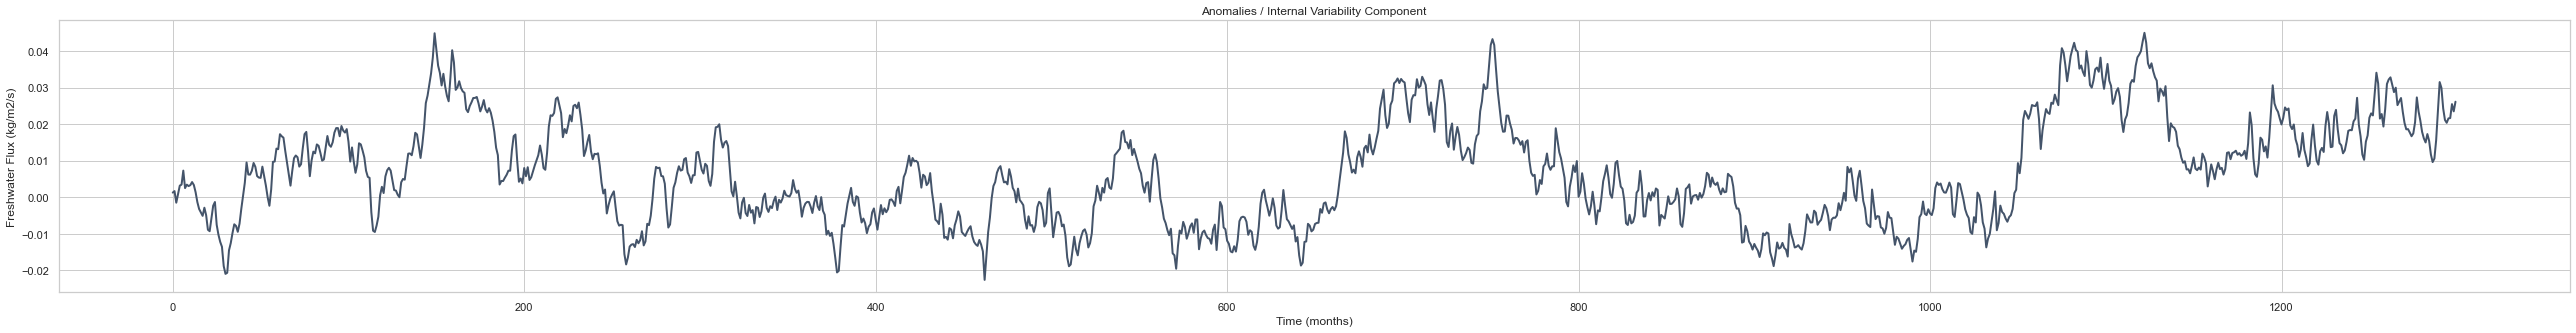

In [174]:
# Figure: Anomalies / Internal Variability Component of Input Data: Temporal Variability
plt.figure(figsize=(45,5))
#plt.plot(flux_anm_ts)
plt.plot(flux_clean_ts[200:], color = '#44546A', linewidth=2)
plt.title('Anomalies / Internal Variability Component')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

## Spatial Decomposition: EOFs

In [8]:
%%time
model = EOF(flux_clean)
model.solve()
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
varexpl = model.explained_variance_ratio()

CPU times: user 2min 32s, sys: 48.7 s, total: 3min 21s
Wall time: 59.8 s


In [11]:
#eofs.to_netcdf(inDirName+interim_data_folder+"fluxclean_eofs.nc")
#pcs.to_netcdf(inDirName+interim_data_folder+"fluxclean_pcs.nc")
#varexpl.to_netcdf(inDirName+interim_data_folder+"fluxclean_varexpl.nc")

In [311]:
# Figure: Relative power of m EOFs

m = 40
plt.figure(figsize=(15,8))
plt.bar(range(m),varexpl[:40]*100, color='#44546A')
plt.ylabel('Relative Power (%)')
plt.xlabel('EOF Mode')
plt.title('Total Relative Power of first {} EOFs: {}'.format(m,varexpl[:m].sum().values*100))

TypeError: 'slice' object is not iterable

<Figure size 1080x576 with 0 Axes>

In [23]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(icems.name)

0           Filchner-Ronne
1                     Ross
2               Antarctica
3                Peninsula
4          West Antarctica
5          East Antarctica
6                   IMBIE1
7                   IMBIE2
8                   IMBIE3
9                   IMBIE4
10                  IMBIE5
11                  IMBIE6
12                  IMBIE7
13                  IMBIE8
14                  IMBIE9
15                 IMBIE10
16                 IMBIE11
17                 IMBIE12
18                 IMBIE13
19                 IMBIE14
20                 IMBIE15
21                 IMBIE16
22                 IMBIE17
23                 IMBIE18
24                 IMBIE19
25                 IMBIE20
26                 IMBIE21
27                 IMBIE22
28                 IMBIE23
29                 IMBIE24
30                 IMBIE25
31                 IMBIE26
32                 IMBIE27
33                   Abbot
34                   Amery
35                    Atka
36                 Aviator
3

In [341]:
snscolors = sns.color_palette("deep")
from matplotlib.projections import get_projection_class

In [323]:
catchments = np.array([1,81,70,71])

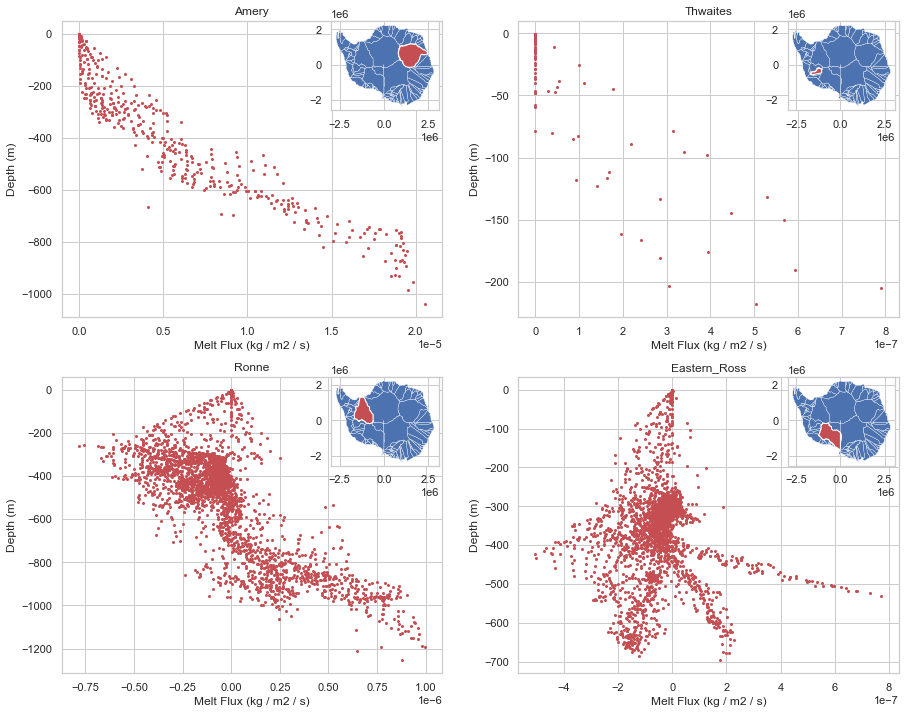

In [343]:
# Figure: Melt rate draft dependence for select catchments
catchment_number = 1 # Select in [0,99]

catchments = np.array([1,81,70,72])

# Amery = 1, Thwaites = 81, Filchner = 22, Ronne = 70, Eastern_Ross = 72, Western_Ross = 71

#fig, ax = plt.subplots(1, 1, figsize=[15, 15],subplot_kw={'projection': ccrs.SouthPolarStereo()})
fig, axs = plt.subplots(2,2, figsize=[15, 12])
axs=axs.ravel()

#axins = inset_axes(ax, width="20%", height="20%")
#axins = axs[0].inset_axes([0.65, 0.6, 0.25, 0.25])

for i in range(4):
    axs[i].scatter(catchments_scatter[catchments[i]],ssh[1],color='r',s=4)
    axs[i].set_xlabel('Melt Flux (kg / m2 / s)')
    axs[i].set_ylabel('Depth (m)')
    axs[i].set_title(icems.name[33+catchments[i]])
    axins = axs[i].inset_axes([0.7, 0.7, 0.3, 0.3])
    icems[33:133].plot(ax=axins,linewidth=0.3)
    icems.loc[[33+catchments[i]],'geometry'].plot(ax=axins,color='r')

# TODO: Polar Stereographic Projection for inset map
# TODO: Convert to m SLE units for flux

In [99]:
abs_max = np.amax(np.abs(eofs))
eof_norm = eofs*1.0/abs_max

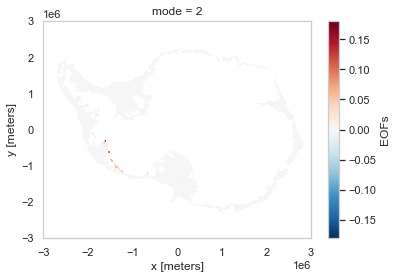

In [313]:
eofs.EOFs[:,:,1].plot()

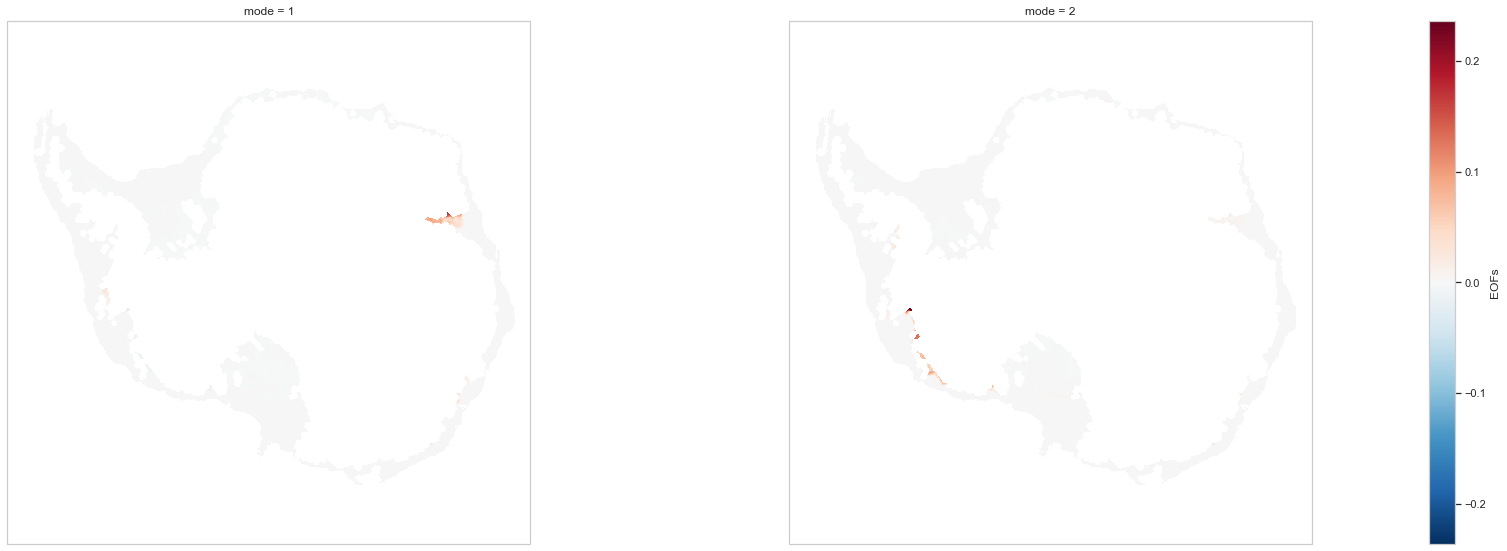

In [169]:
# Figure: Dominant EOF modes
fg = eof_norm[:,:,0:2].plot(aspect=2,
                            size=8,
                            col="mode", 
                            col_wrap=2,
                            subplot_kws=dict(projection=ccrs.SouthPolarStereo()))

# TODO: Redefine vmax, vmin 

## Fourier Phase Randomization

In [190]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 5
t_length = pcs.PCs.shape[0]

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,pcs.PCs.shape[0],pcs.PCs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(nmodes):
        fl = pcs.PCs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
        print('calculated ifft for realization {}, mode: {}'.format(i,m))

calculated ifft for realization 0, mode: 0
calculated ifft for realization 0, mode: 1
calculated ifft for realization 0, mode: 2
calculated ifft for realization 0, mode: 3
calculated ifft for realization 0, mode: 4
calculated ifft for realization 0, mode: 5
calculated ifft for realization 0, mode: 6
calculated ifft for realization 0, mode: 7
calculated ifft for realization 0, mode: 8
calculated ifft for realization 0, mode: 9
calculated ifft for realization 0, mode: 10
calculated ifft for realization 0, mode: 11
calculated ifft for realization 0, mode: 12
calculated ifft for realization 0, mode: 13
calculated ifft for realization 0, mode: 14
calculated ifft for realization 0, mode: 15
calculated ifft for realization 0, mode: 16
calculated ifft for realization 0, mode: 17
calculated ifft for realization 0, mode: 18
calculated ifft for realization 0, mode: 19
calculated ifft for realization 0, mode: 20
calculated ifft for realization 0, mode: 21
calculated ifft for realization 0, mode: 2

calculated ifft for realization 0, mode: 216
calculated ifft for realization 0, mode: 217
calculated ifft for realization 0, mode: 218
calculated ifft for realization 0, mode: 219
calculated ifft for realization 0, mode: 220
calculated ifft for realization 0, mode: 221
calculated ifft for realization 0, mode: 222
calculated ifft for realization 0, mode: 223
calculated ifft for realization 0, mode: 224
calculated ifft for realization 0, mode: 225
calculated ifft for realization 0, mode: 226
calculated ifft for realization 0, mode: 227
calculated ifft for realization 0, mode: 228
calculated ifft for realization 0, mode: 229
calculated ifft for realization 0, mode: 230
calculated ifft for realization 0, mode: 231
calculated ifft for realization 0, mode: 232
calculated ifft for realization 0, mode: 233
calculated ifft for realization 0, mode: 234
calculated ifft for realization 0, mode: 235
calculated ifft for realization 0, mode: 236
calculated ifft for realization 0, mode: 237
calculated

calculated ifft for realization 0, mode: 436
calculated ifft for realization 0, mode: 437
calculated ifft for realization 0, mode: 438
calculated ifft for realization 0, mode: 439
calculated ifft for realization 0, mode: 440
calculated ifft for realization 0, mode: 441
calculated ifft for realization 0, mode: 442
calculated ifft for realization 0, mode: 443
calculated ifft for realization 0, mode: 444
calculated ifft for realization 0, mode: 445
calculated ifft for realization 0, mode: 446
calculated ifft for realization 0, mode: 447
calculated ifft for realization 0, mode: 448
calculated ifft for realization 0, mode: 449
calculated ifft for realization 0, mode: 450
calculated ifft for realization 0, mode: 451
calculated ifft for realization 0, mode: 452
calculated ifft for realization 0, mode: 453
calculated ifft for realization 0, mode: 454
calculated ifft for realization 0, mode: 455
calculated ifft for realization 0, mode: 456
calculated ifft for realization 0, mode: 457
calculated

calculated ifft for realization 0, mode: 646
calculated ifft for realization 0, mode: 647
calculated ifft for realization 0, mode: 648
calculated ifft for realization 0, mode: 649
calculated ifft for realization 0, mode: 650
calculated ifft for realization 0, mode: 651
calculated ifft for realization 0, mode: 652
calculated ifft for realization 0, mode: 653
calculated ifft for realization 0, mode: 654
calculated ifft for realization 0, mode: 655
calculated ifft for realization 0, mode: 656
calculated ifft for realization 0, mode: 657
calculated ifft for realization 0, mode: 658
calculated ifft for realization 0, mode: 659
calculated ifft for realization 0, mode: 660
calculated ifft for realization 0, mode: 661
calculated ifft for realization 0, mode: 662
calculated ifft for realization 0, mode: 663
calculated ifft for realization 0, mode: 664
calculated ifft for realization 0, mode: 665
calculated ifft for realization 0, mode: 666
calculated ifft for realization 0, mode: 667
calculated

calculated ifft for realization 0, mode: 866
calculated ifft for realization 0, mode: 867
calculated ifft for realization 0, mode: 868
calculated ifft for realization 0, mode: 869
calculated ifft for realization 0, mode: 870
calculated ifft for realization 0, mode: 871
calculated ifft for realization 0, mode: 872
calculated ifft for realization 0, mode: 873
calculated ifft for realization 0, mode: 874
calculated ifft for realization 0, mode: 875
calculated ifft for realization 0, mode: 876
calculated ifft for realization 0, mode: 877
calculated ifft for realization 0, mode: 878
calculated ifft for realization 0, mode: 879
calculated ifft for realization 0, mode: 880
calculated ifft for realization 0, mode: 881
calculated ifft for realization 0, mode: 882
calculated ifft for realization 0, mode: 883
calculated ifft for realization 0, mode: 884
calculated ifft for realization 0, mode: 885
calculated ifft for realization 0, mode: 886
calculated ifft for realization 0, mode: 887
calculated

calculated ifft for realization 0, mode: 1082
calculated ifft for realization 0, mode: 1083
calculated ifft for realization 0, mode: 1084
calculated ifft for realization 0, mode: 1085
calculated ifft for realization 0, mode: 1086
calculated ifft for realization 0, mode: 1087
calculated ifft for realization 0, mode: 1088
calculated ifft for realization 0, mode: 1089
calculated ifft for realization 0, mode: 1090
calculated ifft for realization 0, mode: 1091
calculated ifft for realization 0, mode: 1092
calculated ifft for realization 0, mode: 1093
calculated ifft for realization 0, mode: 1094
calculated ifft for realization 0, mode: 1095
calculated ifft for realization 0, mode: 1096
calculated ifft for realization 0, mode: 1097
calculated ifft for realization 0, mode: 1098
calculated ifft for realization 0, mode: 1099
calculated ifft for realization 0, mode: 1100
calculated ifft for realization 0, mode: 1101
calculated ifft for realization 0, mode: 1102
calculated ifft for realization 0,

calculated ifft for realization 0, mode: 1299
calculated ifft for realization 0, mode: 1300
calculated ifft for realization 0, mode: 1301
calculated ifft for realization 0, mode: 1302
calculated ifft for realization 0, mode: 1303
calculated ifft for realization 0, mode: 1304
calculated ifft for realization 0, mode: 1305
calculated ifft for realization 0, mode: 1306
calculated ifft for realization 0, mode: 1307
calculated ifft for realization 0, mode: 1308
calculated ifft for realization 0, mode: 1309
calculated ifft for realization 0, mode: 1310
calculated ifft for realization 0, mode: 1311
calculated ifft for realization 0, mode: 1312
calculated ifft for realization 0, mode: 1313
calculated ifft for realization 0, mode: 1314
calculated ifft for realization 0, mode: 1315
calculated ifft for realization 0, mode: 1316
calculated ifft for realization 0, mode: 1317
calculated ifft for realization 0, mode: 1318
calculated ifft for realization 0, mode: 1319
calculated ifft for realization 0,

calculated ifft for realization 1, mode: 75
calculated ifft for realization 1, mode: 76
calculated ifft for realization 1, mode: 77
calculated ifft for realization 1, mode: 78
calculated ifft for realization 1, mode: 79
calculated ifft for realization 1, mode: 80
calculated ifft for realization 1, mode: 81
calculated ifft for realization 1, mode: 82
calculated ifft for realization 1, mode: 83
calculated ifft for realization 1, mode: 84
calculated ifft for realization 1, mode: 85
calculated ifft for realization 1, mode: 86
calculated ifft for realization 1, mode: 87
calculated ifft for realization 1, mode: 88
calculated ifft for realization 1, mode: 89
calculated ifft for realization 1, mode: 90
calculated ifft for realization 1, mode: 91
calculated ifft for realization 1, mode: 92
calculated ifft for realization 1, mode: 93
calculated ifft for realization 1, mode: 94
calculated ifft for realization 1, mode: 95
calculated ifft for realization 1, mode: 96
calculated ifft for realization 

calculated ifft for realization 1, mode: 296
calculated ifft for realization 1, mode: 297
calculated ifft for realization 1, mode: 298
calculated ifft for realization 1, mode: 299
calculated ifft for realization 1, mode: 300
calculated ifft for realization 1, mode: 301
calculated ifft for realization 1, mode: 302
calculated ifft for realization 1, mode: 303
calculated ifft for realization 1, mode: 304
calculated ifft for realization 1, mode: 305
calculated ifft for realization 1, mode: 306
calculated ifft for realization 1, mode: 307
calculated ifft for realization 1, mode: 308
calculated ifft for realization 1, mode: 309
calculated ifft for realization 1, mode: 310
calculated ifft for realization 1, mode: 311
calculated ifft for realization 1, mode: 312
calculated ifft for realization 1, mode: 313
calculated ifft for realization 1, mode: 314
calculated ifft for realization 1, mode: 315
calculated ifft for realization 1, mode: 316
calculated ifft for realization 1, mode: 317
calculated

calculated ifft for realization 1, mode: 517
calculated ifft for realization 1, mode: 518
calculated ifft for realization 1, mode: 519
calculated ifft for realization 1, mode: 520
calculated ifft for realization 1, mode: 521
calculated ifft for realization 1, mode: 522
calculated ifft for realization 1, mode: 523
calculated ifft for realization 1, mode: 524
calculated ifft for realization 1, mode: 525
calculated ifft for realization 1, mode: 526
calculated ifft for realization 1, mode: 527
calculated ifft for realization 1, mode: 528
calculated ifft for realization 1, mode: 529
calculated ifft for realization 1, mode: 530
calculated ifft for realization 1, mode: 531
calculated ifft for realization 1, mode: 532
calculated ifft for realization 1, mode: 533
calculated ifft for realization 1, mode: 534
calculated ifft for realization 1, mode: 535
calculated ifft for realization 1, mode: 536
calculated ifft for realization 1, mode: 537
calculated ifft for realization 1, mode: 538
calculated

calculated ifft for realization 1, mode: 738
calculated ifft for realization 1, mode: 739
calculated ifft for realization 1, mode: 740
calculated ifft for realization 1, mode: 741
calculated ifft for realization 1, mode: 742
calculated ifft for realization 1, mode: 743
calculated ifft for realization 1, mode: 744
calculated ifft for realization 1, mode: 745
calculated ifft for realization 1, mode: 746
calculated ifft for realization 1, mode: 747
calculated ifft for realization 1, mode: 748
calculated ifft for realization 1, mode: 749
calculated ifft for realization 1, mode: 750
calculated ifft for realization 1, mode: 751
calculated ifft for realization 1, mode: 752
calculated ifft for realization 1, mode: 753
calculated ifft for realization 1, mode: 754
calculated ifft for realization 1, mode: 755
calculated ifft for realization 1, mode: 756
calculated ifft for realization 1, mode: 757
calculated ifft for realization 1, mode: 758
calculated ifft for realization 1, mode: 759
calculated

calculated ifft for realization 1, mode: 962
calculated ifft for realization 1, mode: 963
calculated ifft for realization 1, mode: 964
calculated ifft for realization 1, mode: 965
calculated ifft for realization 1, mode: 966
calculated ifft for realization 1, mode: 967
calculated ifft for realization 1, mode: 968
calculated ifft for realization 1, mode: 969
calculated ifft for realization 1, mode: 970
calculated ifft for realization 1, mode: 971
calculated ifft for realization 1, mode: 972
calculated ifft for realization 1, mode: 973
calculated ifft for realization 1, mode: 974
calculated ifft for realization 1, mode: 975
calculated ifft for realization 1, mode: 976
calculated ifft for realization 1, mode: 977
calculated ifft for realization 1, mode: 978
calculated ifft for realization 1, mode: 979
calculated ifft for realization 1, mode: 980
calculated ifft for realization 1, mode: 981
calculated ifft for realization 1, mode: 982
calculated ifft for realization 1, mode: 983
calculated

calculated ifft for realization 1, mode: 1175
calculated ifft for realization 1, mode: 1176
calculated ifft for realization 1, mode: 1177
calculated ifft for realization 1, mode: 1178
calculated ifft for realization 1, mode: 1179
calculated ifft for realization 1, mode: 1180
calculated ifft for realization 1, mode: 1181
calculated ifft for realization 1, mode: 1182
calculated ifft for realization 1, mode: 1183
calculated ifft for realization 1, mode: 1184
calculated ifft for realization 1, mode: 1185
calculated ifft for realization 1, mode: 1186
calculated ifft for realization 1, mode: 1187
calculated ifft for realization 1, mode: 1188
calculated ifft for realization 1, mode: 1189
calculated ifft for realization 1, mode: 1190
calculated ifft for realization 1, mode: 1191
calculated ifft for realization 1, mode: 1192
calculated ifft for realization 1, mode: 1193
calculated ifft for realization 1, mode: 1194
calculated ifft for realization 1, mode: 1195
calculated ifft for realization 1,

calculated ifft for realization 1, mode: 1392
calculated ifft for realization 1, mode: 1393
calculated ifft for realization 1, mode: 1394
calculated ifft for realization 1, mode: 1395
calculated ifft for realization 1, mode: 1396
calculated ifft for realization 1, mode: 1397
calculated ifft for realization 1, mode: 1398
calculated ifft for realization 1, mode: 1399
calculated ifft for realization 1, mode: 1400
calculated ifft for realization 1, mode: 1401
calculated ifft for realization 1, mode: 1402
calculated ifft for realization 1, mode: 1403
calculated ifft for realization 1, mode: 1404
calculated ifft for realization 1, mode: 1405
calculated ifft for realization 1, mode: 1406
calculated ifft for realization 1, mode: 1407
calculated ifft for realization 1, mode: 1408
calculated ifft for realization 1, mode: 1409
calculated ifft for realization 1, mode: 1410
calculated ifft for realization 1, mode: 1411
calculated ifft for realization 1, mode: 1412
calculated ifft for realization 1,

calculated ifft for realization 2, mode: 109
calculated ifft for realization 2, mode: 110
calculated ifft for realization 2, mode: 111
calculated ifft for realization 2, mode: 112
calculated ifft for realization 2, mode: 113
calculated ifft for realization 2, mode: 114
calculated ifft for realization 2, mode: 115
calculated ifft for realization 2, mode: 116
calculated ifft for realization 2, mode: 117
calculated ifft for realization 2, mode: 118
calculated ifft for realization 2, mode: 119
calculated ifft for realization 2, mode: 120
calculated ifft for realization 2, mode: 121
calculated ifft for realization 2, mode: 122
calculated ifft for realization 2, mode: 123
calculated ifft for realization 2, mode: 124
calculated ifft for realization 2, mode: 125
calculated ifft for realization 2, mode: 126
calculated ifft for realization 2, mode: 127
calculated ifft for realization 2, mode: 128
calculated ifft for realization 2, mode: 129
calculated ifft for realization 2, mode: 130
calculated

calculated ifft for realization 2, mode: 330
calculated ifft for realization 2, mode: 331
calculated ifft for realization 2, mode: 332
calculated ifft for realization 2, mode: 333
calculated ifft for realization 2, mode: 334
calculated ifft for realization 2, mode: 335
calculated ifft for realization 2, mode: 336
calculated ifft for realization 2, mode: 337
calculated ifft for realization 2, mode: 338
calculated ifft for realization 2, mode: 339
calculated ifft for realization 2, mode: 340
calculated ifft for realization 2, mode: 341
calculated ifft for realization 2, mode: 342
calculated ifft for realization 2, mode: 343
calculated ifft for realization 2, mode: 344
calculated ifft for realization 2, mode: 345
calculated ifft for realization 2, mode: 346
calculated ifft for realization 2, mode: 347
calculated ifft for realization 2, mode: 348
calculated ifft for realization 2, mode: 349
calculated ifft for realization 2, mode: 350
calculated ifft for realization 2, mode: 351
calculated

calculated ifft for realization 2, mode: 552
calculated ifft for realization 2, mode: 553
calculated ifft for realization 2, mode: 554
calculated ifft for realization 2, mode: 555
calculated ifft for realization 2, mode: 556
calculated ifft for realization 2, mode: 557
calculated ifft for realization 2, mode: 558
calculated ifft for realization 2, mode: 559
calculated ifft for realization 2, mode: 560
calculated ifft for realization 2, mode: 561
calculated ifft for realization 2, mode: 562
calculated ifft for realization 2, mode: 563
calculated ifft for realization 2, mode: 564
calculated ifft for realization 2, mode: 565
calculated ifft for realization 2, mode: 566
calculated ifft for realization 2, mode: 567
calculated ifft for realization 2, mode: 568
calculated ifft for realization 2, mode: 569
calculated ifft for realization 2, mode: 570
calculated ifft for realization 2, mode: 571
calculated ifft for realization 2, mode: 572
calculated ifft for realization 2, mode: 573
calculated

calculated ifft for realization 2, mode: 776
calculated ifft for realization 2, mode: 777
calculated ifft for realization 2, mode: 778
calculated ifft for realization 2, mode: 779
calculated ifft for realization 2, mode: 780
calculated ifft for realization 2, mode: 781
calculated ifft for realization 2, mode: 782
calculated ifft for realization 2, mode: 783
calculated ifft for realization 2, mode: 784
calculated ifft for realization 2, mode: 785
calculated ifft for realization 2, mode: 786
calculated ifft for realization 2, mode: 787
calculated ifft for realization 2, mode: 788
calculated ifft for realization 2, mode: 789
calculated ifft for realization 2, mode: 790
calculated ifft for realization 2, mode: 791
calculated ifft for realization 2, mode: 792
calculated ifft for realization 2, mode: 793
calculated ifft for realization 2, mode: 794
calculated ifft for realization 2, mode: 795
calculated ifft for realization 2, mode: 796
calculated ifft for realization 2, mode: 797
calculated

calculated ifft for realization 2, mode: 993
calculated ifft for realization 2, mode: 994
calculated ifft for realization 2, mode: 995
calculated ifft for realization 2, mode: 996
calculated ifft for realization 2, mode: 997
calculated ifft for realization 2, mode: 998
calculated ifft for realization 2, mode: 999
calculated ifft for realization 2, mode: 1000
calculated ifft for realization 2, mode: 1001
calculated ifft for realization 2, mode: 1002
calculated ifft for realization 2, mode: 1003
calculated ifft for realization 2, mode: 1004
calculated ifft for realization 2, mode: 1005
calculated ifft for realization 2, mode: 1006
calculated ifft for realization 2, mode: 1007
calculated ifft for realization 2, mode: 1008
calculated ifft for realization 2, mode: 1009
calculated ifft for realization 2, mode: 1010
calculated ifft for realization 2, mode: 1011
calculated ifft for realization 2, mode: 1012
calculated ifft for realization 2, mode: 1013
calculated ifft for realization 2, mode: 

calculated ifft for realization 2, mode: 1208
calculated ifft for realization 2, mode: 1209
calculated ifft for realization 2, mode: 1210
calculated ifft for realization 2, mode: 1211
calculated ifft for realization 2, mode: 1212
calculated ifft for realization 2, mode: 1213
calculated ifft for realization 2, mode: 1214
calculated ifft for realization 2, mode: 1215
calculated ifft for realization 2, mode: 1216
calculated ifft for realization 2, mode: 1217
calculated ifft for realization 2, mode: 1218
calculated ifft for realization 2, mode: 1219
calculated ifft for realization 2, mode: 1220
calculated ifft for realization 2, mode: 1221
calculated ifft for realization 2, mode: 1222
calculated ifft for realization 2, mode: 1223
calculated ifft for realization 2, mode: 1224
calculated ifft for realization 2, mode: 1225
calculated ifft for realization 2, mode: 1226
calculated ifft for realization 2, mode: 1227
calculated ifft for realization 2, mode: 1228
calculated ifft for realization 2,

calculated ifft for realization 2, mode: 1428
calculated ifft for realization 2, mode: 1429
calculated ifft for realization 2, mode: 1430
calculated ifft for realization 2, mode: 1431
calculated ifft for realization 2, mode: 1432
calculated ifft for realization 2, mode: 1433
calculated ifft for realization 2, mode: 1434
calculated ifft for realization 2, mode: 1435
calculated ifft for realization 2, mode: 1436
calculated ifft for realization 2, mode: 1437
calculated ifft for realization 2, mode: 1438
calculated ifft for realization 2, mode: 1439
calculated ifft for realization 2, mode: 1440
calculated ifft for realization 2, mode: 1441
calculated ifft for realization 2, mode: 1442
calculated ifft for realization 2, mode: 1443
calculated ifft for realization 2, mode: 1444
calculated ifft for realization 2, mode: 1445
calculated ifft for realization 2, mode: 1446
calculated ifft for realization 2, mode: 1447
calculated ifft for realization 2, mode: 1448
calculated ifft for realization 2,

calculated ifft for realization 3, mode: 150
calculated ifft for realization 3, mode: 151
calculated ifft for realization 3, mode: 152
calculated ifft for realization 3, mode: 153
calculated ifft for realization 3, mode: 154
calculated ifft for realization 3, mode: 155
calculated ifft for realization 3, mode: 156
calculated ifft for realization 3, mode: 157
calculated ifft for realization 3, mode: 158
calculated ifft for realization 3, mode: 159
calculated ifft for realization 3, mode: 160
calculated ifft for realization 3, mode: 161
calculated ifft for realization 3, mode: 162
calculated ifft for realization 3, mode: 163
calculated ifft for realization 3, mode: 164
calculated ifft for realization 3, mode: 165
calculated ifft for realization 3, mode: 166
calculated ifft for realization 3, mode: 167
calculated ifft for realization 3, mode: 168
calculated ifft for realization 3, mode: 169
calculated ifft for realization 3, mode: 170
calculated ifft for realization 3, mode: 171
calculated

calculated ifft for realization 3, mode: 368
calculated ifft for realization 3, mode: 369
calculated ifft for realization 3, mode: 370
calculated ifft for realization 3, mode: 371
calculated ifft for realization 3, mode: 372
calculated ifft for realization 3, mode: 373
calculated ifft for realization 3, mode: 374
calculated ifft for realization 3, mode: 375
calculated ifft for realization 3, mode: 376
calculated ifft for realization 3, mode: 377
calculated ifft for realization 3, mode: 378
calculated ifft for realization 3, mode: 379
calculated ifft for realization 3, mode: 380
calculated ifft for realization 3, mode: 381
calculated ifft for realization 3, mode: 382
calculated ifft for realization 3, mode: 383
calculated ifft for realization 3, mode: 384
calculated ifft for realization 3, mode: 385
calculated ifft for realization 3, mode: 386
calculated ifft for realization 3, mode: 387
calculated ifft for realization 3, mode: 388
calculated ifft for realization 3, mode: 389
calculated

calculated ifft for realization 3, mode: 577
calculated ifft for realization 3, mode: 578
calculated ifft for realization 3, mode: 579
calculated ifft for realization 3, mode: 580
calculated ifft for realization 3, mode: 581
calculated ifft for realization 3, mode: 582
calculated ifft for realization 3, mode: 583
calculated ifft for realization 3, mode: 584
calculated ifft for realization 3, mode: 585
calculated ifft for realization 3, mode: 586
calculated ifft for realization 3, mode: 587
calculated ifft for realization 3, mode: 588
calculated ifft for realization 3, mode: 589
calculated ifft for realization 3, mode: 590
calculated ifft for realization 3, mode: 591
calculated ifft for realization 3, mode: 592
calculated ifft for realization 3, mode: 593
calculated ifft for realization 3, mode: 594
calculated ifft for realization 3, mode: 595
calculated ifft for realization 3, mode: 596
calculated ifft for realization 3, mode: 597
calculated ifft for realization 3, mode: 598
calculated

calculated ifft for realization 3, mode: 787
calculated ifft for realization 3, mode: 788
calculated ifft for realization 3, mode: 789
calculated ifft for realization 3, mode: 790
calculated ifft for realization 3, mode: 791
calculated ifft for realization 3, mode: 792
calculated ifft for realization 3, mode: 793
calculated ifft for realization 3, mode: 794
calculated ifft for realization 3, mode: 795
calculated ifft for realization 3, mode: 796
calculated ifft for realization 3, mode: 797
calculated ifft for realization 3, mode: 798
calculated ifft for realization 3, mode: 799
calculated ifft for realization 3, mode: 800
calculated ifft for realization 3, mode: 801
calculated ifft for realization 3, mode: 802
calculated ifft for realization 3, mode: 803
calculated ifft for realization 3, mode: 804
calculated ifft for realization 3, mode: 805
calculated ifft for realization 3, mode: 806
calculated ifft for realization 3, mode: 807
calculated ifft for realization 3, mode: 808
calculated

calculated ifft for realization 3, mode: 1002
calculated ifft for realization 3, mode: 1003
calculated ifft for realization 3, mode: 1004
calculated ifft for realization 3, mode: 1005
calculated ifft for realization 3, mode: 1006
calculated ifft for realization 3, mode: 1007
calculated ifft for realization 3, mode: 1008
calculated ifft for realization 3, mode: 1009
calculated ifft for realization 3, mode: 1010
calculated ifft for realization 3, mode: 1011
calculated ifft for realization 3, mode: 1012
calculated ifft for realization 3, mode: 1013
calculated ifft for realization 3, mode: 1014
calculated ifft for realization 3, mode: 1015
calculated ifft for realization 3, mode: 1016
calculated ifft for realization 3, mode: 1017
calculated ifft for realization 3, mode: 1018
calculated ifft for realization 3, mode: 1019
calculated ifft for realization 3, mode: 1020
calculated ifft for realization 3, mode: 1021
calculated ifft for realization 3, mode: 1022
calculated ifft for realization 3,

calculated ifft for realization 3, mode: 1229
calculated ifft for realization 3, mode: 1230
calculated ifft for realization 3, mode: 1231
calculated ifft for realization 3, mode: 1232
calculated ifft for realization 3, mode: 1233
calculated ifft for realization 3, mode: 1234
calculated ifft for realization 3, mode: 1235
calculated ifft for realization 3, mode: 1236
calculated ifft for realization 3, mode: 1237
calculated ifft for realization 3, mode: 1238
calculated ifft for realization 3, mode: 1239
calculated ifft for realization 3, mode: 1240
calculated ifft for realization 3, mode: 1241
calculated ifft for realization 3, mode: 1242
calculated ifft for realization 3, mode: 1243
calculated ifft for realization 3, mode: 1244
calculated ifft for realization 3, mode: 1245
calculated ifft for realization 3, mode: 1246
calculated ifft for realization 3, mode: 1247
calculated ifft for realization 3, mode: 1248
calculated ifft for realization 3, mode: 1249
calculated ifft for realization 3,

calculated ifft for realization 3, mode: 1455
calculated ifft for realization 3, mode: 1456
calculated ifft for realization 3, mode: 1457
calculated ifft for realization 3, mode: 1458
calculated ifft for realization 3, mode: 1459
calculated ifft for realization 3, mode: 1460
calculated ifft for realization 3, mode: 1461
calculated ifft for realization 3, mode: 1462
calculated ifft for realization 3, mode: 1463
calculated ifft for realization 3, mode: 1464
calculated ifft for realization 3, mode: 1465
calculated ifft for realization 3, mode: 1466
calculated ifft for realization 3, mode: 1467
calculated ifft for realization 3, mode: 1468
calculated ifft for realization 3, mode: 1469
calculated ifft for realization 3, mode: 1470
calculated ifft for realization 3, mode: 1471
calculated ifft for realization 3, mode: 1472
calculated ifft for realization 3, mode: 1473
calculated ifft for realization 3, mode: 1474
calculated ifft for realization 3, mode: 1475
calculated ifft for realization 3,

calculated ifft for realization 4, mode: 181
calculated ifft for realization 4, mode: 182
calculated ifft for realization 4, mode: 183
calculated ifft for realization 4, mode: 184
calculated ifft for realization 4, mode: 185
calculated ifft for realization 4, mode: 186
calculated ifft for realization 4, mode: 187
calculated ifft for realization 4, mode: 188
calculated ifft for realization 4, mode: 189
calculated ifft for realization 4, mode: 190
calculated ifft for realization 4, mode: 191
calculated ifft for realization 4, mode: 192
calculated ifft for realization 4, mode: 193
calculated ifft for realization 4, mode: 194
calculated ifft for realization 4, mode: 195
calculated ifft for realization 4, mode: 196
calculated ifft for realization 4, mode: 197
calculated ifft for realization 4, mode: 198
calculated ifft for realization 4, mode: 199
calculated ifft for realization 4, mode: 200
calculated ifft for realization 4, mode: 201
calculated ifft for realization 4, mode: 202
calculated

calculated ifft for realization 4, mode: 407
calculated ifft for realization 4, mode: 408
calculated ifft for realization 4, mode: 409
calculated ifft for realization 4, mode: 410
calculated ifft for realization 4, mode: 411
calculated ifft for realization 4, mode: 412
calculated ifft for realization 4, mode: 413
calculated ifft for realization 4, mode: 414
calculated ifft for realization 4, mode: 415
calculated ifft for realization 4, mode: 416
calculated ifft for realization 4, mode: 417
calculated ifft for realization 4, mode: 418
calculated ifft for realization 4, mode: 419
calculated ifft for realization 4, mode: 420
calculated ifft for realization 4, mode: 421
calculated ifft for realization 4, mode: 422
calculated ifft for realization 4, mode: 423
calculated ifft for realization 4, mode: 424
calculated ifft for realization 4, mode: 425
calculated ifft for realization 4, mode: 426
calculated ifft for realization 4, mode: 427
calculated ifft for realization 4, mode: 428
calculated

calculated ifft for realization 4, mode: 634
calculated ifft for realization 4, mode: 635
calculated ifft for realization 4, mode: 636
calculated ifft for realization 4, mode: 637
calculated ifft for realization 4, mode: 638
calculated ifft for realization 4, mode: 639
calculated ifft for realization 4, mode: 640
calculated ifft for realization 4, mode: 641
calculated ifft for realization 4, mode: 642
calculated ifft for realization 4, mode: 643
calculated ifft for realization 4, mode: 644
calculated ifft for realization 4, mode: 645
calculated ifft for realization 4, mode: 646
calculated ifft for realization 4, mode: 647
calculated ifft for realization 4, mode: 648
calculated ifft for realization 4, mode: 649
calculated ifft for realization 4, mode: 650
calculated ifft for realization 4, mode: 651
calculated ifft for realization 4, mode: 652
calculated ifft for realization 4, mode: 653
calculated ifft for realization 4, mode: 654
calculated ifft for realization 4, mode: 655
calculated

calculated ifft for realization 4, mode: 860
calculated ifft for realization 4, mode: 861
calculated ifft for realization 4, mode: 862
calculated ifft for realization 4, mode: 863
calculated ifft for realization 4, mode: 864
calculated ifft for realization 4, mode: 865
calculated ifft for realization 4, mode: 866
calculated ifft for realization 4, mode: 867
calculated ifft for realization 4, mode: 868
calculated ifft for realization 4, mode: 869
calculated ifft for realization 4, mode: 870
calculated ifft for realization 4, mode: 871
calculated ifft for realization 4, mode: 872
calculated ifft for realization 4, mode: 873
calculated ifft for realization 4, mode: 874
calculated ifft for realization 4, mode: 875
calculated ifft for realization 4, mode: 876
calculated ifft for realization 4, mode: 877
calculated ifft for realization 4, mode: 878
calculated ifft for realization 4, mode: 879
calculated ifft for realization 4, mode: 880
calculated ifft for realization 4, mode: 881
calculated

calculated ifft for realization 4, mode: 1085
calculated ifft for realization 4, mode: 1086
calculated ifft for realization 4, mode: 1087
calculated ifft for realization 4, mode: 1088
calculated ifft for realization 4, mode: 1089
calculated ifft for realization 4, mode: 1090
calculated ifft for realization 4, mode: 1091
calculated ifft for realization 4, mode: 1092
calculated ifft for realization 4, mode: 1093
calculated ifft for realization 4, mode: 1094
calculated ifft for realization 4, mode: 1095
calculated ifft for realization 4, mode: 1096
calculated ifft for realization 4, mode: 1097
calculated ifft for realization 4, mode: 1098
calculated ifft for realization 4, mode: 1099
calculated ifft for realization 4, mode: 1100
calculated ifft for realization 4, mode: 1101
calculated ifft for realization 4, mode: 1102
calculated ifft for realization 4, mode: 1103
calculated ifft for realization 4, mode: 1104
calculated ifft for realization 4, mode: 1105
calculated ifft for realization 4,

calculated ifft for realization 4, mode: 1313
calculated ifft for realization 4, mode: 1314
calculated ifft for realization 4, mode: 1315
calculated ifft for realization 4, mode: 1316
calculated ifft for realization 4, mode: 1317
calculated ifft for realization 4, mode: 1318
calculated ifft for realization 4, mode: 1319
calculated ifft for realization 4, mode: 1320
calculated ifft for realization 4, mode: 1321
calculated ifft for realization 4, mode: 1322
calculated ifft for realization 4, mode: 1323
calculated ifft for realization 4, mode: 1324
calculated ifft for realization 4, mode: 1325
calculated ifft for realization 4, mode: 1326
calculated ifft for realization 4, mode: 1327
calculated ifft for realization 4, mode: 1328
calculated ifft for realization 4, mode: 1329
calculated ifft for realization 4, mode: 1330
calculated ifft for realization 4, mode: 1331
calculated ifft for realization 4, mode: 1332
calculated ifft for realization 4, mode: 1333
calculated ifft for realization 4,

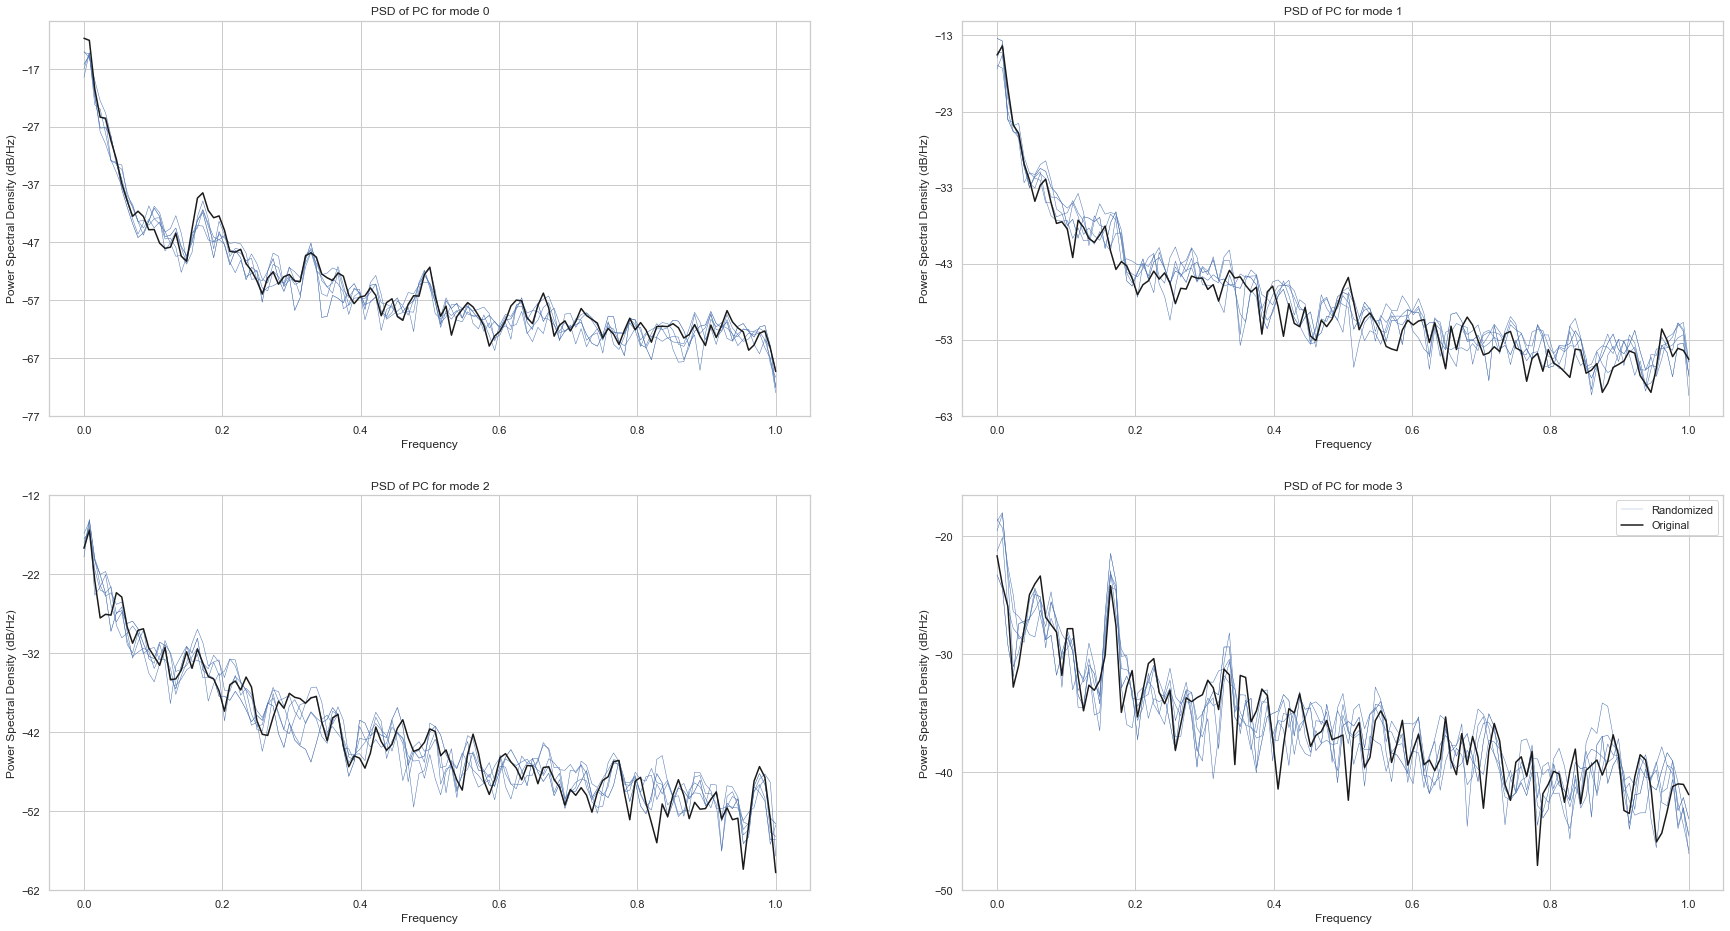

In [195]:
# FIGURE (FOR TESTING)

fig, axs = plt.subplots(2,2,figsize=(30,16))
axs=axs.ravel()

for mode_m in range(0,4):
    for i in range(0,5):
        axs[mode_m].psd(new_fl[i,:,mode_m],color='b', linewidth=0.5)
    axs[mode_m].psd(new_fl[0,:,mode_m],color='b', linewidth=0.25,label='Randomized')
    axs[mode_m].psd(pcs.PCs[:,mode_m],color='k', linewidth=1.5,label='Original')
    axs[mode_m].set_title('PSD of PC for mode {}'.format(mode_m))
plt.legend()

In [196]:
#modified to not return f - in calculation of RMSE, only Px required
def psd_calc_grid(data,y,x):
    f, Px = scipy.signal.welch(data[:,y,x])
    return Px

In [197]:
def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

In [201]:
# Reconstruct flux dataset using phase randomized PCs
# This section is to be called iteratively for ensemble runs with multiple realizations
# This method also takes 'modes' as a parameter: 
# which is used to reconstruct dataset with different number of selected modes

def generate_data(n_realization,mode,mode_skip):
    flux_reconstr = model.reconstruct_randomized_X(new_fl[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    #flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr

In [199]:
def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping))
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    clipped_data = clipped_data.drop("month")
    return clipped_data

In [202]:
clipped_amery = clip_data(flux_clean, 34)

In [301]:
# Generate dataset realizations
for i in range(n_realizations):
    flux_reconstr = generate_data(i, 65, 1)
    flux_reconstr.to_netcdf(inDirName+interim_data_folder+cise_file_path+"flux_reconstr_65_{}.nc".format(i))
    del flux_reconstr
    gc.collect()
    print('reconstructed realization # {}'.format(i))

reconstructed realization # 0
reconstructed realization # 1
reconstructed realization # 2
reconstructed realization # 3
reconstructed realization # 4


In [302]:
basins = np.array((34,55,114,103,104,105))

In [303]:
for basin in basins:
    orig = clip_data(flux_clean, basin)
    rec0 = clip_data(flux_reconstr0, basin)
    rec1 = clip_data(flux_reconstr1, basin)
    rec2 = clip_data(flux_reconstr2, basin)
    rec3 = clip_data(flux_reconstr3, basin)
    rec4 = clip_data(flux_reconstr4, basin)
    orig.to_netcdf(inDirName+interim_data_folder+cise_file_path+"orig_m65_{}".format(basin))
    rec0.to_netcdf(inDirName+interim_data_folder+cise_file_path+"rec0_m65_{}".format(basin))
    rec1.to_netcdf(inDirName+interim_data_folder+cise_file_path+"rec1_m65_{}".format(basin))
    rec2.to_netcdf(inDirName+interim_data_folder+cise_file_path+"rec2_m65_{}".format(basin))
    rec3.to_netcdf(inDirName+interim_data_folder+cise_file_path+"rec3_m65_{}".format(basin))
    rec4.to_netcdf(inDirName+interim_data_folder+cise_file_path+"rec4_m65_{}".format(basin))
    del orig, rec0, rec1, rec2, rec3, rec4
    gc.collect()

In [264]:
# Amery 34
orig_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_34")
rec0_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_34")
rec1_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_34")
rec2_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_34")
rec3_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_34")
rec4_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_34")

# Filchner 55
orig_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_55")
rec0_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_55")
rec1_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_55")
rec2_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_55")
rec3_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_55")
rec4_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_55")

# Thwaites 114
orig_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_114")
rec0_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_114")
rec1_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_114")
rec2_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_114")
rec3_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_114")
rec4_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_114")

# Ronne 103
orig_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_103")
rec0_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_103")
rec1_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_103")
rec2_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_103")
rec3_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_103")
rec4_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_103")

# Western Ross 104
orig_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_104")
rec0_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_104")
rec1_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_104")
rec2_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_104")
rec3_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_104")
rec4_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_104")

# Eastern Ross 105
orig_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_105")
rec0_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_105")
rec1_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_105")
rec2_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_105")
rec3_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_105")
rec4_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_105")

In [304]:
# Amery 34
orig_m65_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_m65_34")
rec0_m65_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_m65_34")
rec1_m65_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_m65_34")
rec2_m65_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_m65_34")
rec3_m65_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_m65_34")
rec4_m65_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_m65_34")

# Filchner 55
orig_m65_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_m65_55")
rec0_m65_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_m65_55")
rec1_m65_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_m65_55")
rec2_m65_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_m65_55")
rec3_m65_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_m65_55")
rec4_m65_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_m65_55")

# Thwaites 114
orig_m65_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_m65_114")
rec0_m65_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_m65_114")
rec1_m65_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_m65_114")
rec2_m65_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_m65_114")
rec3_m65_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_m65_114")
rec4_m65_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_m65_114")

# Ronne 103
orig_m65_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_m65_103")
rec0_m65_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_m65_103")
rec1_m65_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_m65_103")
rec2_m65_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_m65_103")
rec3_m65_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_m65_103")
rec4_m65_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_m65_103")

# Western Ross 104
orig_m65_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_m65_104")
rec0_m65_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_m65_104")
rec1_m65_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_m65_104")
rec2_m65_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_m65_104")
rec3_m65_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_m65_104")
rec4_m65_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_m65_104")

# Eastern Ross 105
orig_m65_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_m65_105")
rec0_m65_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_m65_105")
rec1_m65_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_m65_105")
rec2_m65_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_m65_105")
rec3_m65_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_m65_105")
rec4_m65_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_m65_105")

In [305]:
# Amery 
orig_m65_34_ts = time_series(orig_m65_34)
rec0_m65_34_ts = time_series(rec0_m65_34)
rec1_m65_34_ts = time_series(rec1_m65_34)
rec2_m65_34_ts = time_series(rec2_m65_34)
rec3_m65_34_ts = time_series(rec3_m65_34)
rec4_m65_34_ts = time_series(rec4_m65_34)

# Filchner 
orig_m65_55_ts = time_series(orig_m65_55)
rec0_m65_55_ts = time_series(rec0_m65_55)
rec1_m65_55_ts = time_series(rec1_m65_55)
rec2_m65_55_ts = time_series(rec2_m65_55)
rec3_m65_55_ts = time_series(rec3_m65_55)
rec4_m65_55_ts = time_series(rec4_m65_55)

# Thwaites 
orig_m65_114_ts = time_series(orig_m65_114)
rec0_m65_114_ts = time_series(rec0_m65_114)
rec1_m65_114_ts = time_series(rec1_m65_114)
rec2_m65_114_ts = time_series(rec2_m65_114)
rec3_m65_114_ts = time_series(rec3_m65_114)
rec4_m65_114_ts = time_series(rec4_m65_114)

# Ronne 
orig_m65_103_ts = time_series(orig_m65_103)
rec0_m65_103_ts = time_series(rec0_m65_103)
rec1_m65_103_ts = time_series(rec1_m65_103)
rec2_m65_103_ts = time_series(rec2_m65_103)
rec3_m65_103_ts = time_series(rec3_m65_103)
rec4_m65_103_ts = time_series(rec4_m65_103)

# Western Ross 
orig_m65_104_ts = time_series(orig_m65_104)
rec0_m65_104_ts = time_series(rec0_m65_104)
rec1_m65_104_ts = time_series(rec1_m65_104)
rec2_m65_104_ts = time_series(rec2_m65_104)
rec3_m65_104_ts = time_series(rec3_m65_104)
rec4_m65_104_ts = time_series(rec4_m65_104)

# Eastern Ross 
orig_m65_105_ts = time_series(orig_m65_105)
rec0_m65_105_ts = time_series(rec0_m65_105)
rec1_m65_105_ts = time_series(rec1_m65_105)
rec2_m65_105_ts = time_series(rec2_m65_105)
rec3_m65_105_ts = time_series(rec3_m65_105)
rec4_m65_105_ts = time_series(rec4_m65_105)

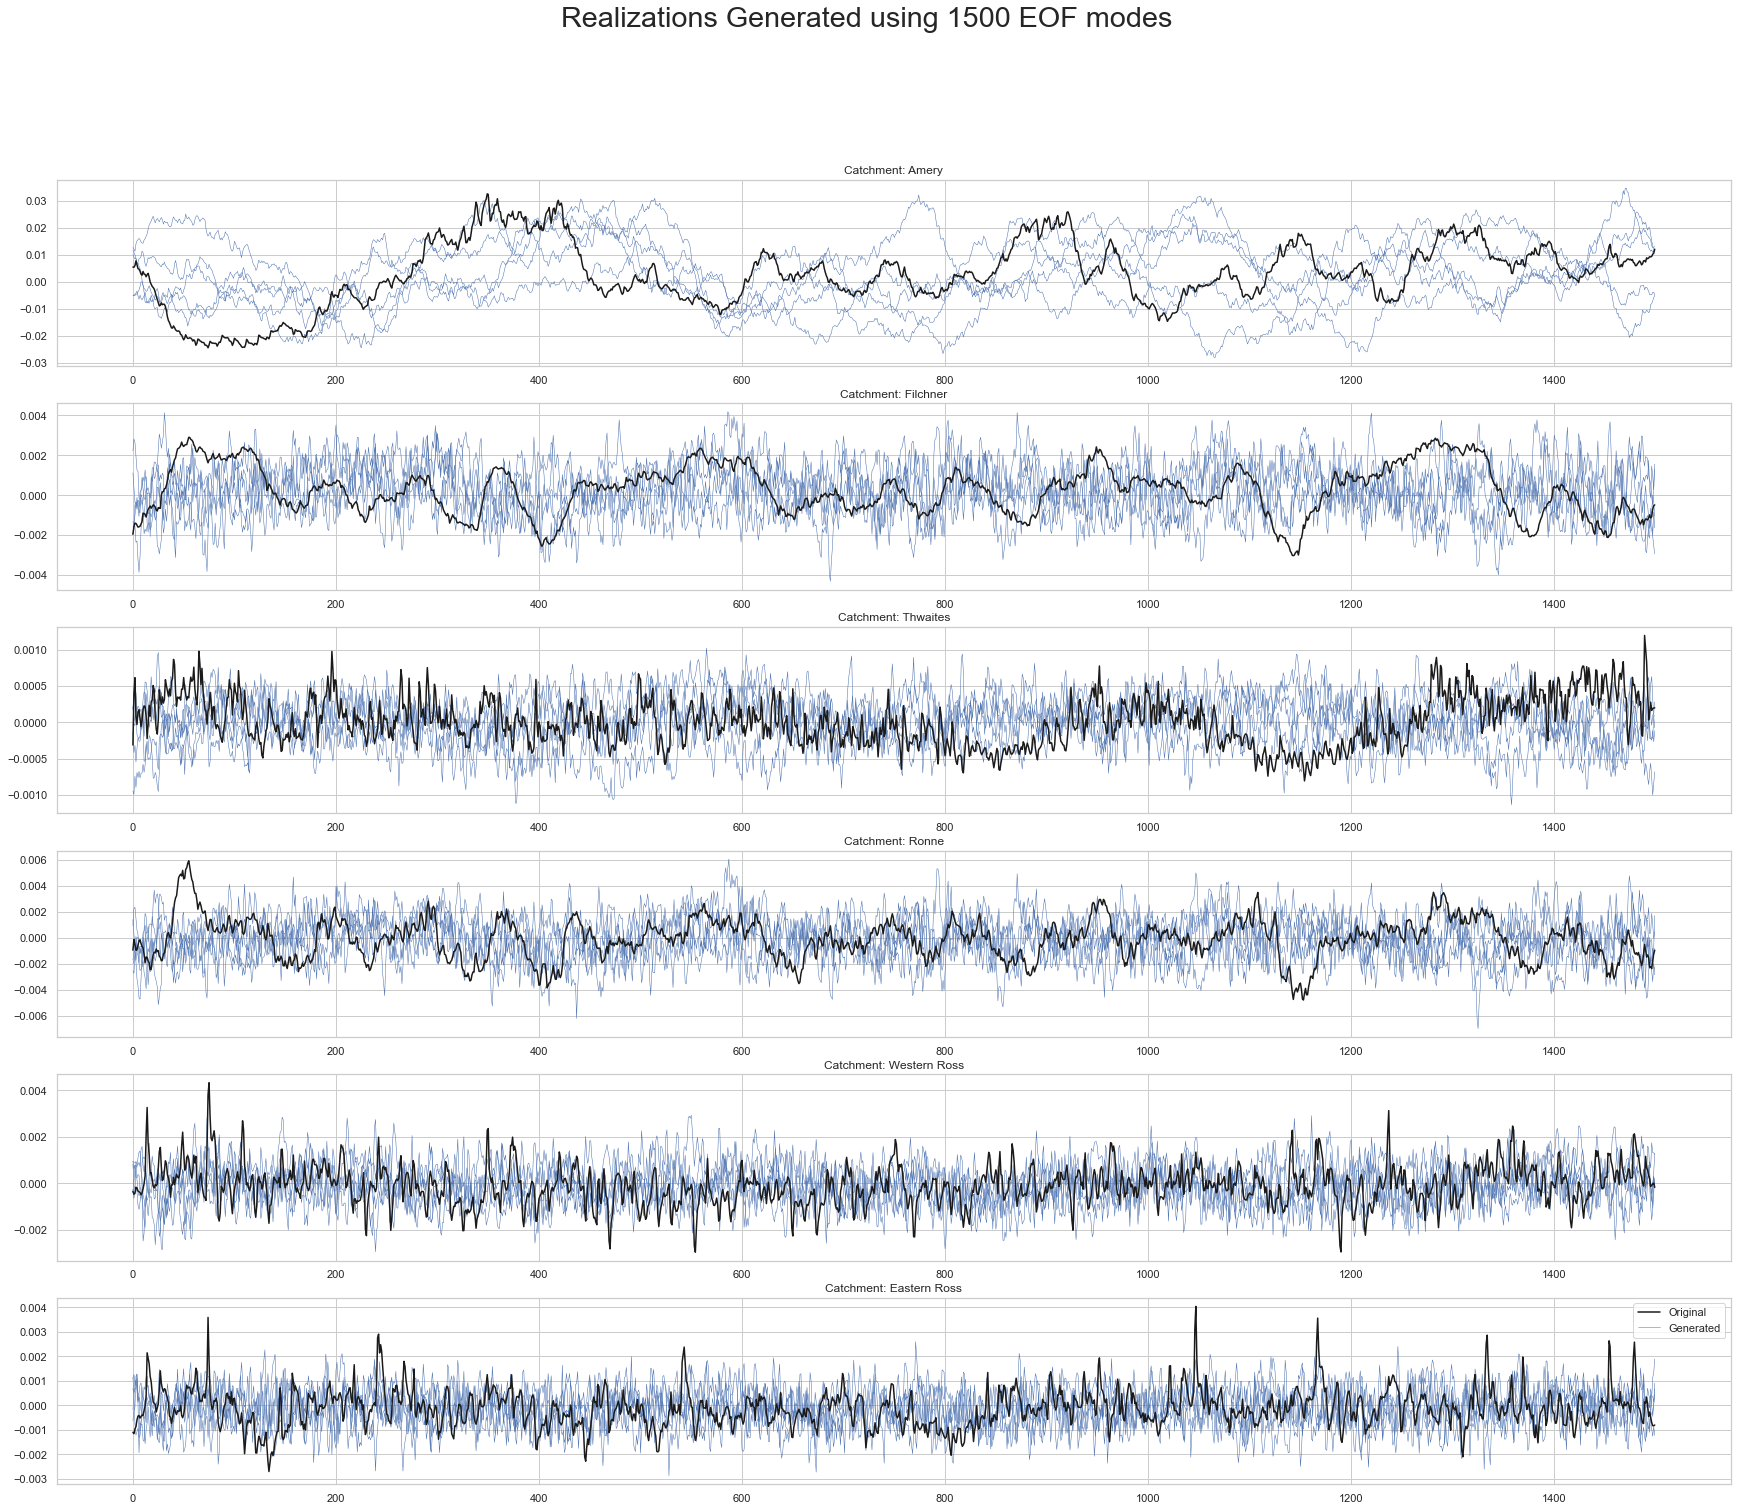

In [289]:
fig, axs = plt.subplots(6,1,figsize=(30,24))
axs=axs.ravel()

axs[0].plot(orig_34_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[0].plot(rec0_34_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[0].plot(rec1_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].plot(rec2_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].plot(rec3_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].plot(rec4_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].set_title('Catchment: Amery');

axs[1].plot(orig_55_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[1].plot(rec0_55_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[1].plot(rec1_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].plot(rec2_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].plot(rec3_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].plot(rec4_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].set_title('Catchment: Filchner');

axs[2].plot(orig_114_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[2].plot(rec0_114_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[2].plot(rec1_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].plot(rec2_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].plot(rec3_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].plot(rec4_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].set_title('Catchment: Thwaites');

axs[3].plot(orig_103_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[3].plot(rec0_103_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[3].plot(rec1_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].plot(rec2_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].plot(rec3_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].plot(rec4_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].set_title('Catchment: Ronne');

axs[4].plot(orig_104_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[4].plot(rec0_104_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[4].plot(rec1_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].plot(rec2_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].plot(rec3_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].plot(rec4_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].set_title('Catchment: Western Ross');

axs[5].plot(orig_105_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[5].plot(rec0_105_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[5].plot(rec1_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].plot(rec2_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].plot(rec3_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].plot(rec4_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].set_title('Catchment: Eastern Ross');
plt.legend()

plt.suptitle('Realizations Generated using 1500 EOF modes');

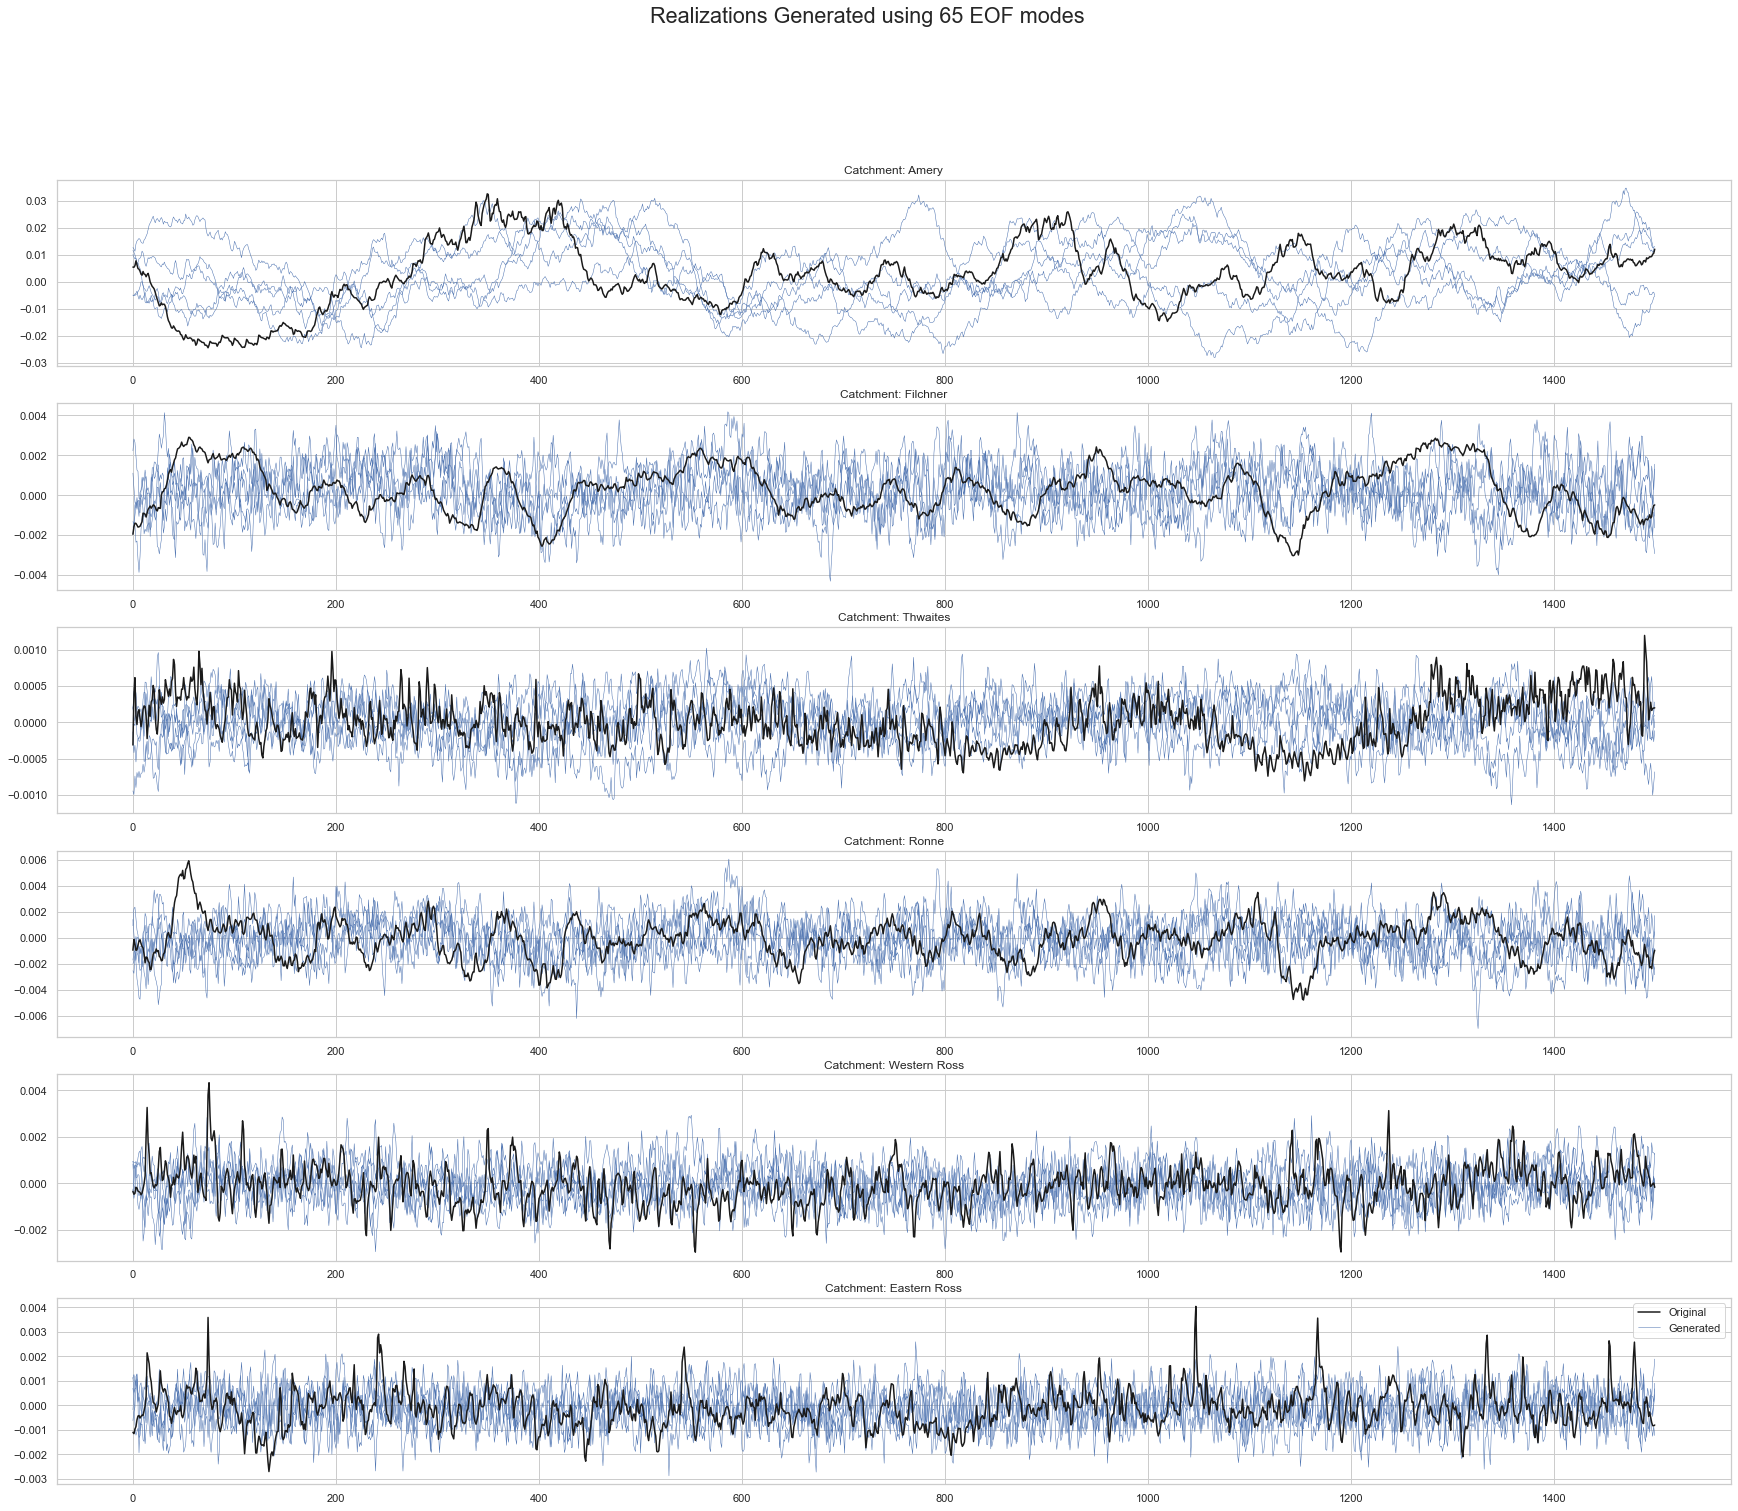

In [307]:
fig, axs = plt.subplots(6,1,figsize=(30,24))
axs=axs.ravel()

axs[0].plot(orig_m65_34_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[0].plot(rec0_m65_34_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[0].plot(rec1_m65_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].plot(rec2_m65_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].plot(rec3_m65_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].plot(rec4_m65_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].set_title('Catchment: Amery');

axs[1].plot(orig_m65_55_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[1].plot(rec0_m65_55_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[1].plot(rec1_m65_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].plot(rec2_m65_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].plot(rec3_m65_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].plot(rec4_m65_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].set_title('Catchment: Filchner');

axs[2].plot(orig_m65_114_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[2].plot(rec0_m65_114_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[2].plot(rec1_m65_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].plot(rec2_m65_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].plot(rec3_m65_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].plot(rec4_m65_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].set_title('Catchment: Thwaites');

axs[3].plot(orig_m65_103_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[3].plot(rec0_m65_103_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[3].plot(rec1_m65_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].plot(rec2_m65_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].plot(rec3_m65_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].plot(rec4_m65_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].set_title('Catchment: Ronne');

axs[4].plot(orig_m65_104_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[4].plot(rec0_m65_104_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[4].plot(rec1_m65_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].plot(rec2_m65_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].plot(rec3_m65_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].plot(rec4_m65_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].set_title('Catchment: Western Ross');

axs[5].plot(orig_m65_105_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[5].plot(rec0_m65_105_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[5].plot(rec1_m65_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].plot(rec2_m65_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].plot(rec3_m65_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].plot(rec4_m65_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].set_title('Catchment: Eastern Ross');
plt.legend()

plt.suptitle('Realizations Generated using 65 EOF modes');

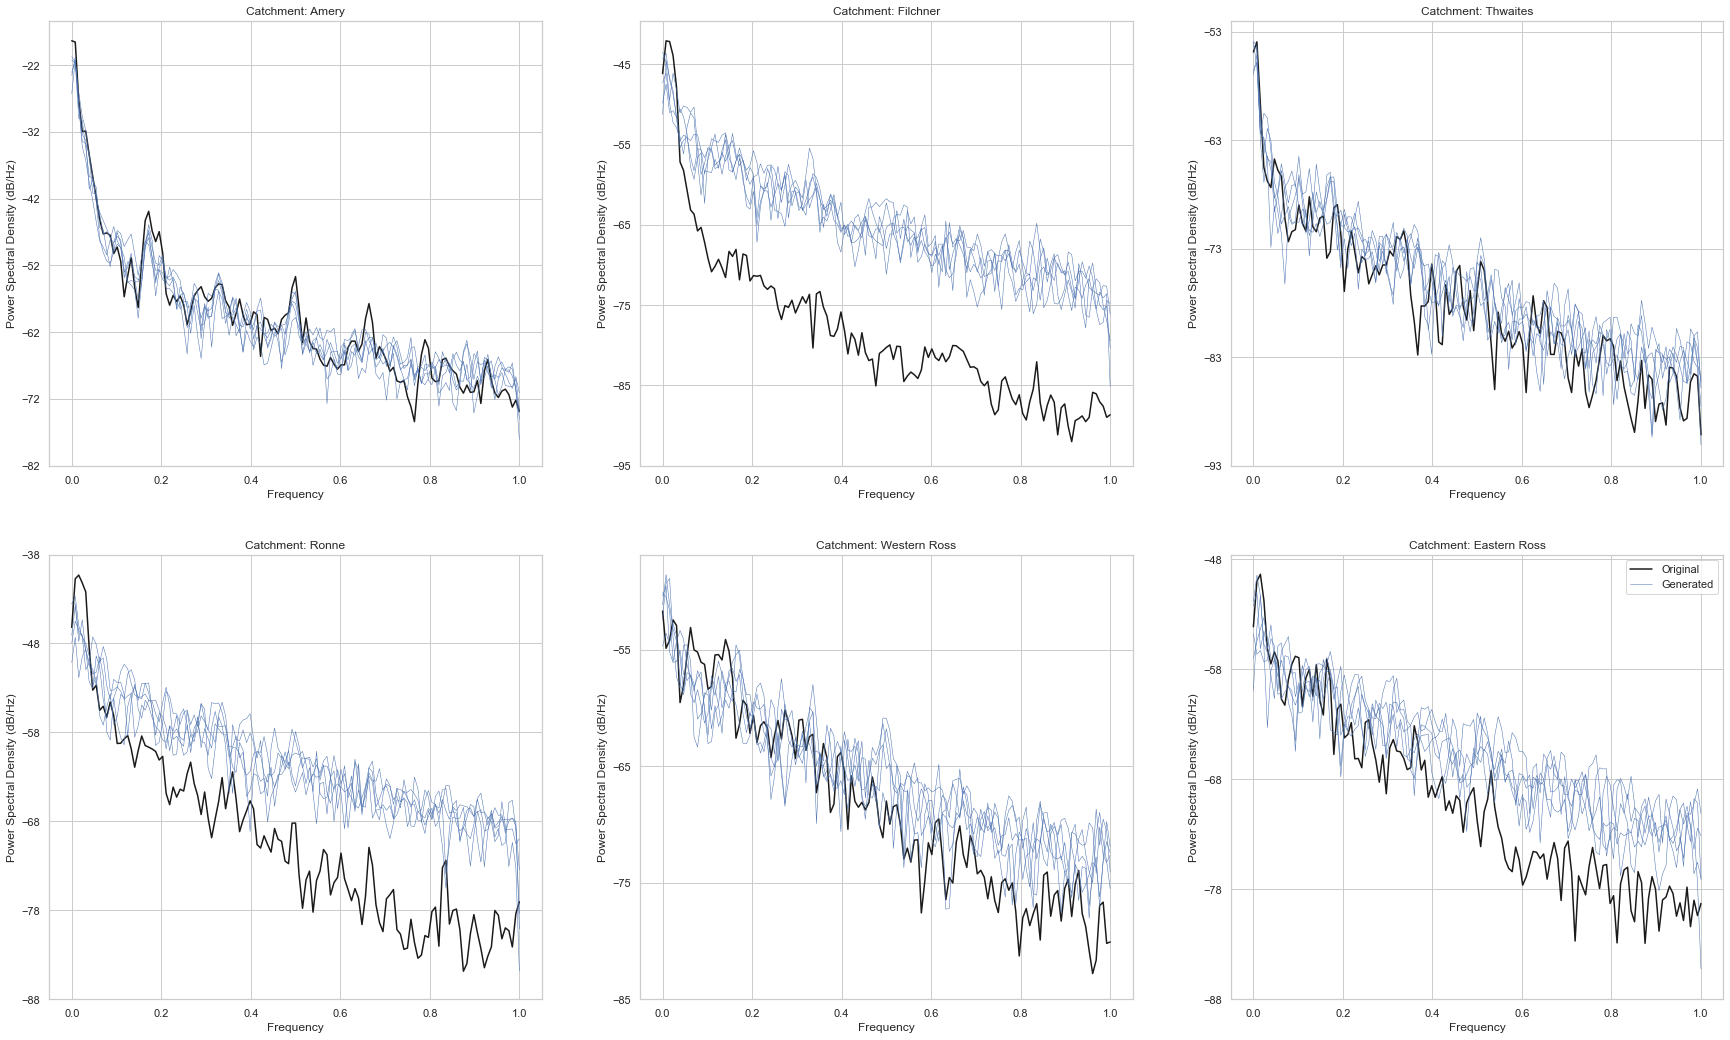

In [308]:
fig, axs = plt.subplots(2,3,figsize=(30,18))
axs=axs.ravel()

axs[0].psd(orig_m65_34_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[0].psd(rec0_m65_34_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[0].psd(rec1_m65_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].psd(rec2_m65_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].psd(rec3_m65_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].psd(rec4_m65_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].set_title('Catchment: Amery');

axs[1].psd(orig_m65_55_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[1].psd(rec0_m65_55_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[1].psd(rec1_m65_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].psd(rec2_m65_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].psd(rec3_m65_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].psd(rec4_m65_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].set_title('Catchment: Filchner');

axs[2].psd(orig_m65_114_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[2].psd(rec0_m65_114_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[2].psd(rec1_m65_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].psd(rec2_m65_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].psd(rec3_m65_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].psd(rec4_m65_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].set_title('Catchment: Thwaites');

axs[3].psd(orig_m65_103_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[3].psd(rec0_m65_103_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[3].psd(rec1_m65_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].psd(rec2_m65_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].psd(rec3_m65_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].psd(rec4_m65_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].set_title('Catchment: Ronne');

axs[4].psd(orig_m65_104_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[4].psd(rec0_m65_104_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[4].psd(rec1_m65_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].psd(rec2_m65_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].psd(rec3_m65_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].psd(rec4_m65_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].set_title('Catchment: Western Ross');

axs[5].psd(orig_m65_105_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[5].psd(rec0_m65_105_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[5].psd(rec1_m65_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].psd(rec2_m65_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].psd(rec3_m65_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].psd(rec4_m65_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].set_title('Catchment: Eastern Ross');
plt.legend()

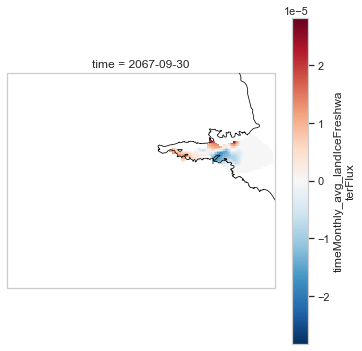

In [277]:
fig, ax = plt.subplots(1, 1, figsize=[6, 6],subplot_kw={'projection': ccrs.SouthPolarStereo()})
ax.coastlines(resolution='10m', zorder=6,linewidth=0.75)
orig_34.timeMonthly_avg_landIceFreshwaterFlux[500].plot(ax=ax)